Imports, loading data set, visualising data set, and setting up for analysis. The goal of this project is to utilize machine learning to devise meaningful ways of classifying or predicting arrythmic ECG signals.

In [2]:
import os
import glob
import re
import wfdb as wf
from wfdb import processing
import numpy as np
import pandas as pd
from collections import Counter
from numpy import matmul, transpose
from matplotlib import pyplot as plt
from scipy import signal
from scipy.sparse import identity
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter, argrelextrema
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score as R2, accuracy_score
from sklearn.model_selection import train_test_split as TTS, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLPC


In [3]:
samplenumber=100000    #sample size for analysis, max 100000 for our data

filenames = glob.glob('DataFiles/*.dat') #reading files from DataFiles folder
pchannelb=[] #initiating arrays
file_nums=[]
pfreq=[]
recordall=[]
annall=[]
pchannel=[]

for i, s in enumerate(filenames):                 
    num_str = re.search("(\d+).dat",  filenames[i]) 
    file_nums.append(num_str.group(1)) #extracting the numbering system of the data files, saving them to an array for calling them in the future 
    
for j, k in enumerate(file_nums):
    record = wf.rdrecord('Datafiles/'+file_nums[j], sampto=samplenumber)
    ann = wf.rdann('DataFiles/'+file_nums[j], 'atr', sampto=samplenumber) #reading the data and annotation files
    if record.sig_name[0] == 'MLII':
        pchannelb.append(record.p_signal[:,0]) #these include different channel data from each patient and pad the annotations accordingly so indexes line up
        annall.append(ann)
        recordall.append(record)
    #if record.sig_name[0] == 'V5':
        #pchannelb.append(record.p_signal[:,0])
        #annall.append(ann)
        #recordall.append(record)
    #if record.sig_name[0] == 'V1':
        #pchannelb.append(record.p_signal[:,0])
        #annall.append(ann)
        #recordall.append(record)
    if record.sig_name[1] == 'MLII':
        pchannelb.append(record.p_signal[:,1])
        annall.append(ann)
        recordall.append(record)
    #if record.sig_name[1] == 'V5':
        #pchannelb.append(record.p_signal[:,1])
        #annall.append(ann)
        #recordall.append(record)
    #if record.sig_name[1] == 'V1':
        #pchannelb.append(record.p_signal[:,1])
        #annall.append(ann)
        #recordall.append(record)
for l, m in enumerate(pchannelb):
    pchannel.append((pchannelb[l] - np.mean(pchannelb[l])) / np.std(pchannelb[l]))
    #wf.plot_wfdb(record=record, annotation = ann, title='Record '+file_nums[j]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,10)) #plotting all of the files

Finding Peaks. This part utilizes the gqrs function in wfdb to find R peaks. The cell following uses a custom algorithm to find all local minima and maxima. Annotations inherent in the data serves the same purpose. Currently the peaks found isn't used for the other steps below, but is an important part of develop if we wish to extract features from new data. Annotations are used currently for data preparation, and this will substitute that in the absence of annotations.

C:\Anaconda3\lib\site-packages\wfdb\processing\hr.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  hr = 60000.0 / rr


Example of Gqrs detected peak indices: [243, 692, 1118, 1552, 1988, 2443, 2884, 3307, 3743, 4155, 4593, 5016, 5457, 5878, 6326, 6756, 7199, 7633, 8072, 8499, 8936, 9355, 9792, 10220, 10660, 11086, 11517, 11951, 12385, 12811, 13235, 13670, 14100, 14527, 14981, 15419, 15865, 16315, 16767, 17199, 17650, 18089, 18537, 18983, 19416, 19868, 20317, 20772, 21221, 21650, 22093, 22532, 22988, 23421, 23897, 24362, 24815, 25252, 25688, 26108, 26539, 26952, 27395, 27852, 28277, 28725, 29138, 29574, 30021, 30450, 30887, 31318, 31754, 32196, 32641, 33084, 33517, 33956, 34396, 34842, 35265, 35689, 36127, 36585, 37033, 37480, 37934, 38370, 38825, 39275, 39716, 40172, 40636, 41088, 41516, 41959, 42380, 42822, 43247, 43680, 44109, 44556, 44975, 45422, 45862, 46298, 46745, 47169, 47608, 48057, 48492, 48928, 49346, 49787, 50210, 50645, 51074, 51507, 51951, 52381, 52826, 53245, 53666, 54104, 54533, 54979, 55393, 55830, 56275, 56710, 57144, 57570, 58017, 58436, 58873, 59295, 59721, 60160, 60586, 61019, 61430

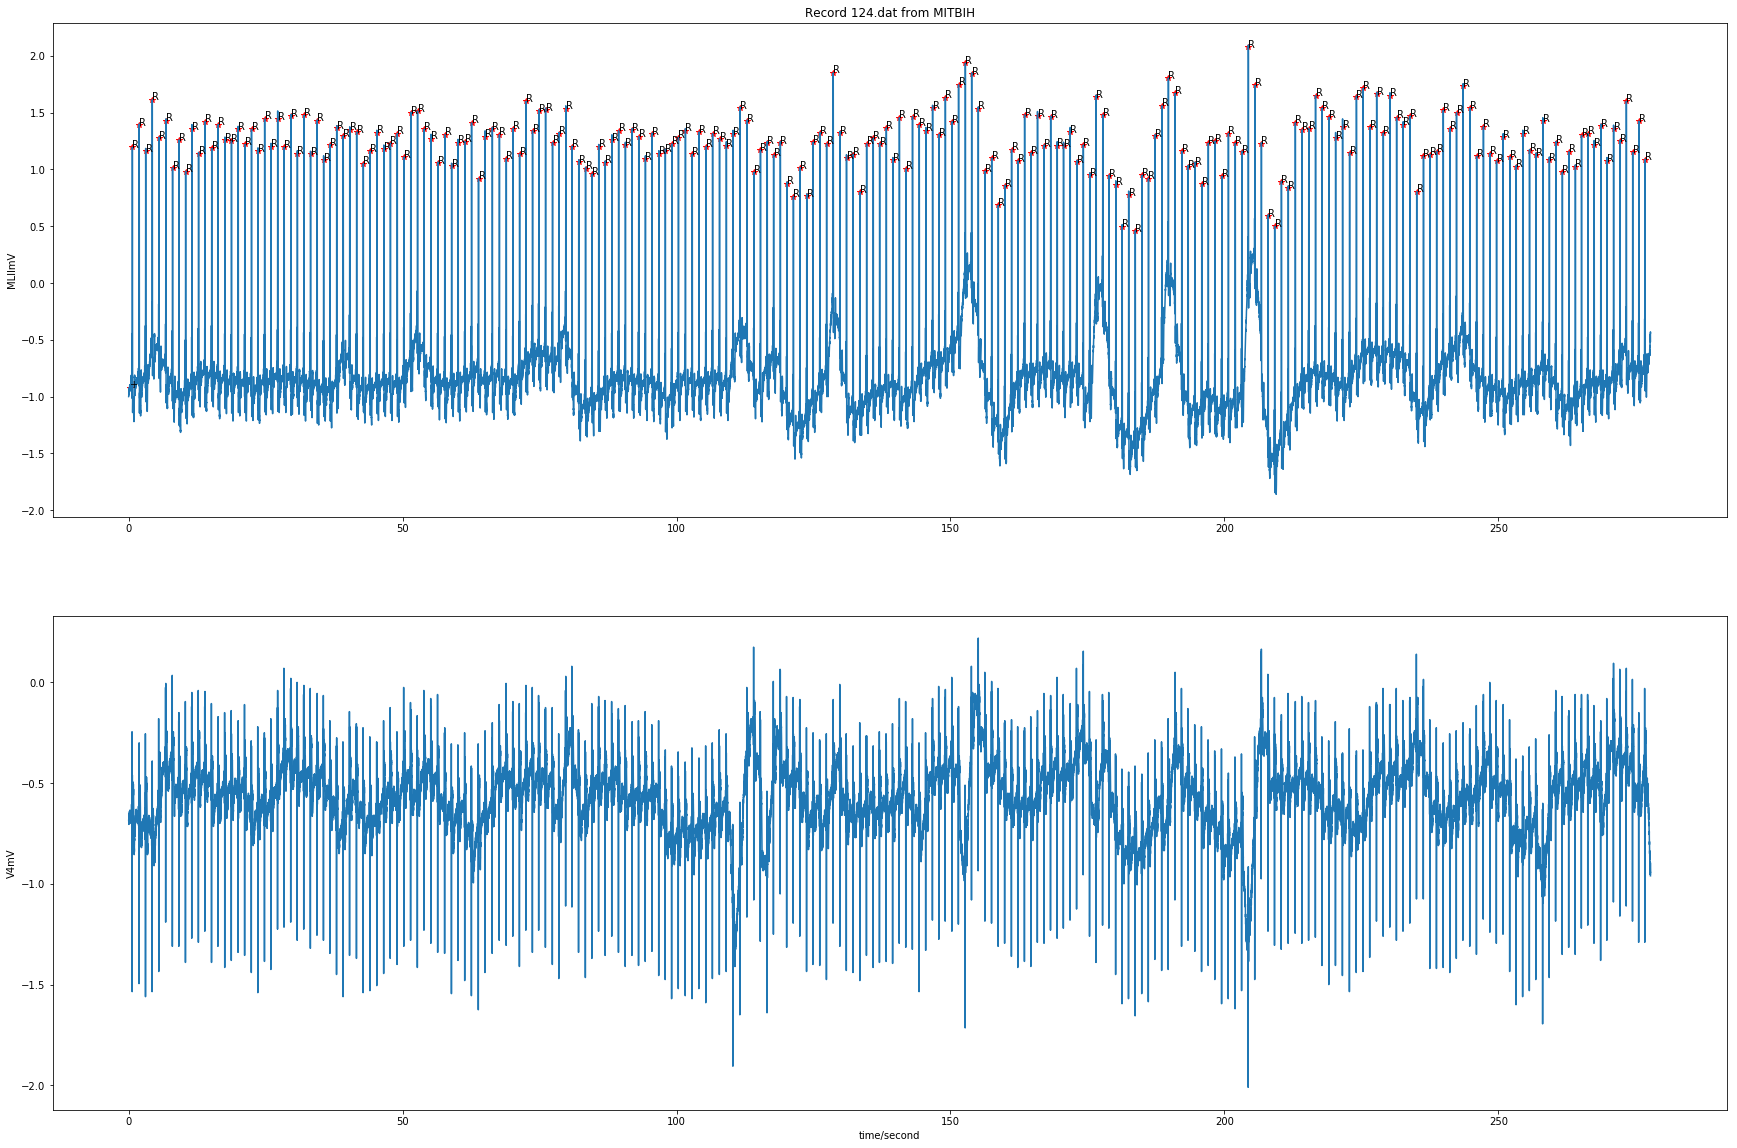

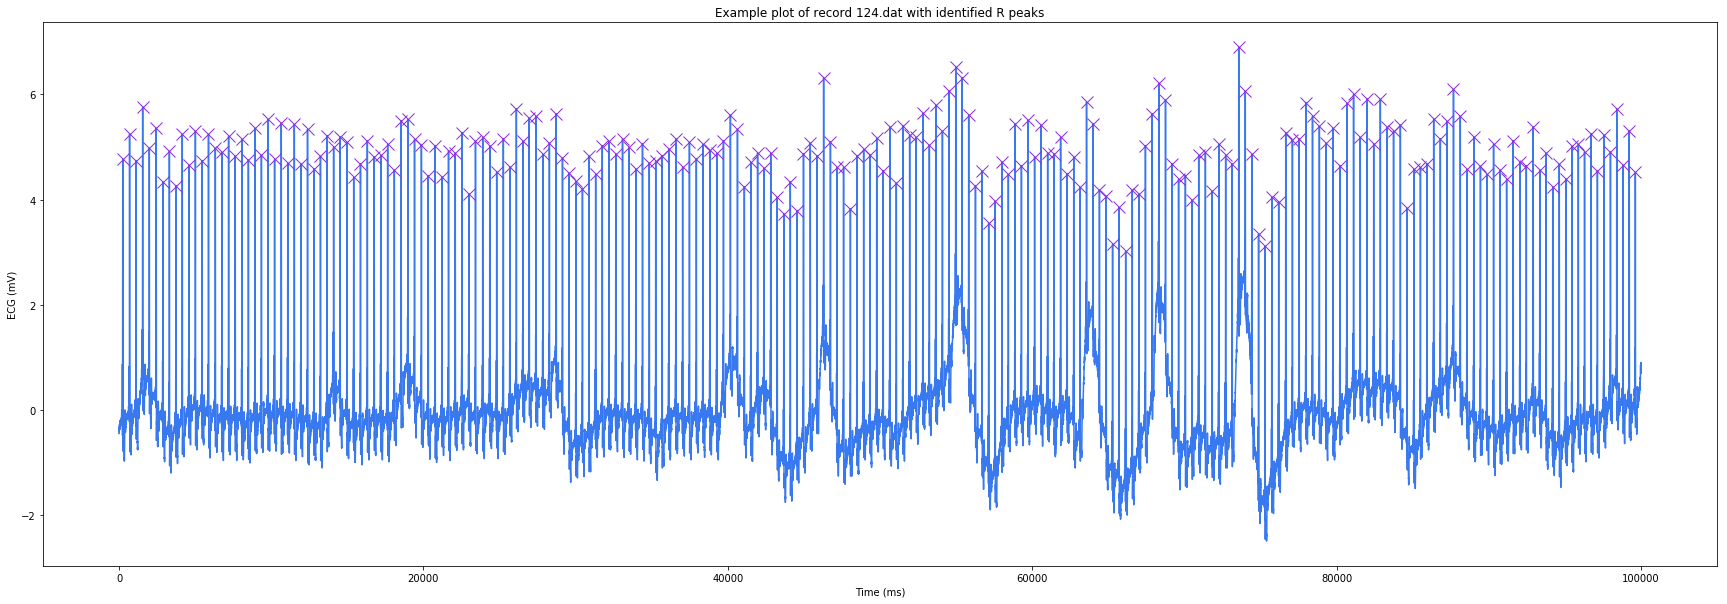

In [4]:
datanumb=20  #which data set to look at

# Use the gqrs algorithm to detect qrs locations in the first channel
search_radius=[]
qrs_inds=[]
peak_inds=[]
hrs=[]
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius

for i in range(len(recordall)): #perform peak finding according to the wfdb package; shown with the actual annotations
    search_radius.append(int(recordall[i].fs * 60 / max_bpm))
    qrs_inds.append(processing.gqrs_detect(sig=pchannel[i], fs=recordall[i].fs))
    peak_inds.append(processing.correct_peaks(pchannel[i], peak_inds=qrs_inds[i], search_radius=search_radius[i], smooth_window_size=100))
    hrs.append(processing.compute_hr(sig_len=pchannel[i].shape[0], qrs_inds=peak_inds[i], fs=recordall[i].fs)) #find heart beat for later feature extraction

print('Example of Gqrs detected peak indices:', sorted(peak_inds[datanumb]))

wf.plot_wfdb(record=recordall[datanumb], annotation = annall[datanumb], title='Record '+str(recordall[datanumb].file_name[0])+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,20))
plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb], color='#3979f0', label='Signal')
plt.plot(peak_inds[datanumb], pchannel[datanumb][peak_inds[datanumb]], 'rx', marker='x', color='#8A2BE2', label='Peak', markersize=12)
plt.title('Example plot of record '+str(recordall[datanumb].file_name[0])+' with identified R peaks')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')

Planned extraction of features based on peak detection. This section finds meaningful maxima/minima outside of R peaks (such as P, Q, S, T). Features could be used for sections below in place of data-specific annotations.

[  100   243   693  1119  1552  1989  2444  2885  3307  3744  4156  4594
  5016  5457  5878  6327  6756  7200  7633  8072  8500  8936  9356  9794
 10220 10661 11087 11517 11952 12386 12812 13236 13671 14100 14528 14981
 15419 15865 16316 16768 17200 17650 18089 18538 18983 19416 19869 20318
 20772 21222 21651 22093 22532 22988 23423 23898 24362 24815 25252 25688
 26108 26540 26953 27396 27852 28278 28726 29139 29575 30022 30450 30888
 31319 31755 32196 32642 33085 33517 33957 34397 34843 35266 35689 36127
 36586 37033 37480 37934 38370 38826 39276 39717 40173 40637 41088 41516
 41960 42380 42823 43248 43680 44110 44557 44975 45423 45862 46298 46746
 47170 47608 48057 48492 48928 49347 49787 50211 50645 51074 51507 51951
 52382 52827 53246 53666 54105 54533 54979 55394 55831 56275 56710 57144
 57571 58017 58436 58873 59295 59722 60161 60587 61020 61431 61871 62300
 62732 63153 63575 64008 64422 64867 65286 65712 66146 66580 67013 67445
 67891 68321 68763 69199 69623 70070 70513 70945 71

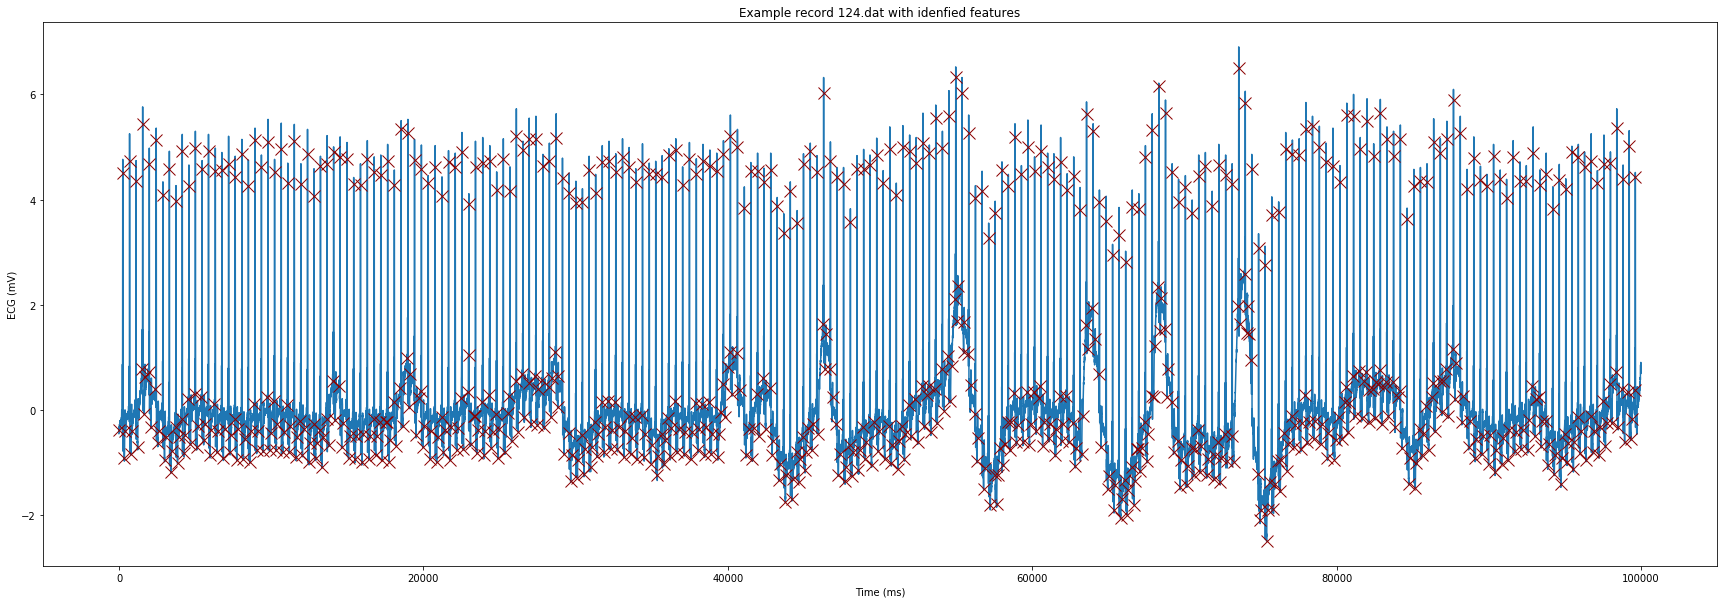

In [5]:
lowcut=.5      #low frequency cutoff for bandpass filter
highcut=3   #high frequency cutoff for bandpass filter
window=10     #window size for moving window integration3

zero_crossings = []

nyquist_freq = 0.5 * record.fs #calculating the nyquist frequency using the sampling frequency
low = lowcut / nyquist_freq #lowpass filtering cutoff
high = highcut / nyquist_freq #highpass filtering cutoff
bf, af = butter(1, [low, high], btype="band")
for i in range(len(pchannel)):
    xf = lfilter(bf, af, pchannel[i]) #bandpass filtering
    yf = np.ediff1d(xf) #deriving the data
    fin = np.convolve(yf, np.ones(window)/window, mode='valid') #moving window average smoothing
    zero_crossings.append(np.where(np.diff(np.sign(fin)))[0]) #find the zero crossings in the differential ie minima and maxima

    mfreq = recordall[i].fs * 0.05 #the minimum datapoints between peaks that's physiologically possible
    mamp = 0.5 #arbitrary amplitude difference to prevent repeated values
    t=0
    l=len(zero_crossings[i]) 
    while t < l-1: #This loop limits the number of local peaks detected through frequency and amplitude so jagged data won't dominate
        if abs(zero_crossings[i][t+1]-zero_crossings[i][t]) < mfreq or abs(pchannel[i][zero_crossings[i][t+1]] - pchannel[i][zero_crossings[i][t]]) < mamp and abs(pchannel[i][zero_crossings[i][t+1]]) > abs(pchannel[i][zero_crossings[i][t]]):
            zero_crossings[i] = np.concatenate((zero_crossings[i][:t], zero_crossings[i][t+1:]))
            l = len(zero_crossings[i])
        elif abs(zero_crossings[i][t+1]-zero_crossings[i][t]) < mfreq or abs(pchannel[i][zero_crossings[i][t+1]] - pchannel[i][zero_crossings[i][t]]) < mamp and abs(pchannel[i][zero_crossings[i][t+1]]) < abs(pchannel[i][zero_crossings[i][t]]):
            zero_crossings[i] = np.concatenate((zero_crossings[i][:t+1], zero_crossings[i][t+2:]))
            l = len(zero_crossings[i])
        else:
            t += 1
            l = len(zero_crossings[i])
       
plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb])
plt.plot(zero_crossings[datanumb][:-2], pchannel[datanumb][zero_crossings[datanumb][:-2]], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
anno = [annall[datanumb].sample, annall[datanumb].symbol]
print(anno[0])
plt.title('Example record '+str(recordall[datanumb].file_name[0])+' with idenfied features')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')

Segmentation of data into time frames based on proximity to arrythmic beat. There are two different ways of separating the data. A) The entire dataset is separated into beats along with their annotations and RR distance. In this case, the raw data of each beat and/or some features/statistics could be put into a one vs all classifier. B) The dataset could be separated into arrythmic beats (desired output) and time frames of beats before the arrythmia (input). These inputs and lagged inputs could be reduced in dimentionality using PCA and then be used for training using machine learning models such as multilayered perceptrons or random forrest classifiers. They could also be transformed using techniques such as Fourier transform to eliminate the time dimension for simplification of fitting.

Part A beat type: N
Part B label of beat is N


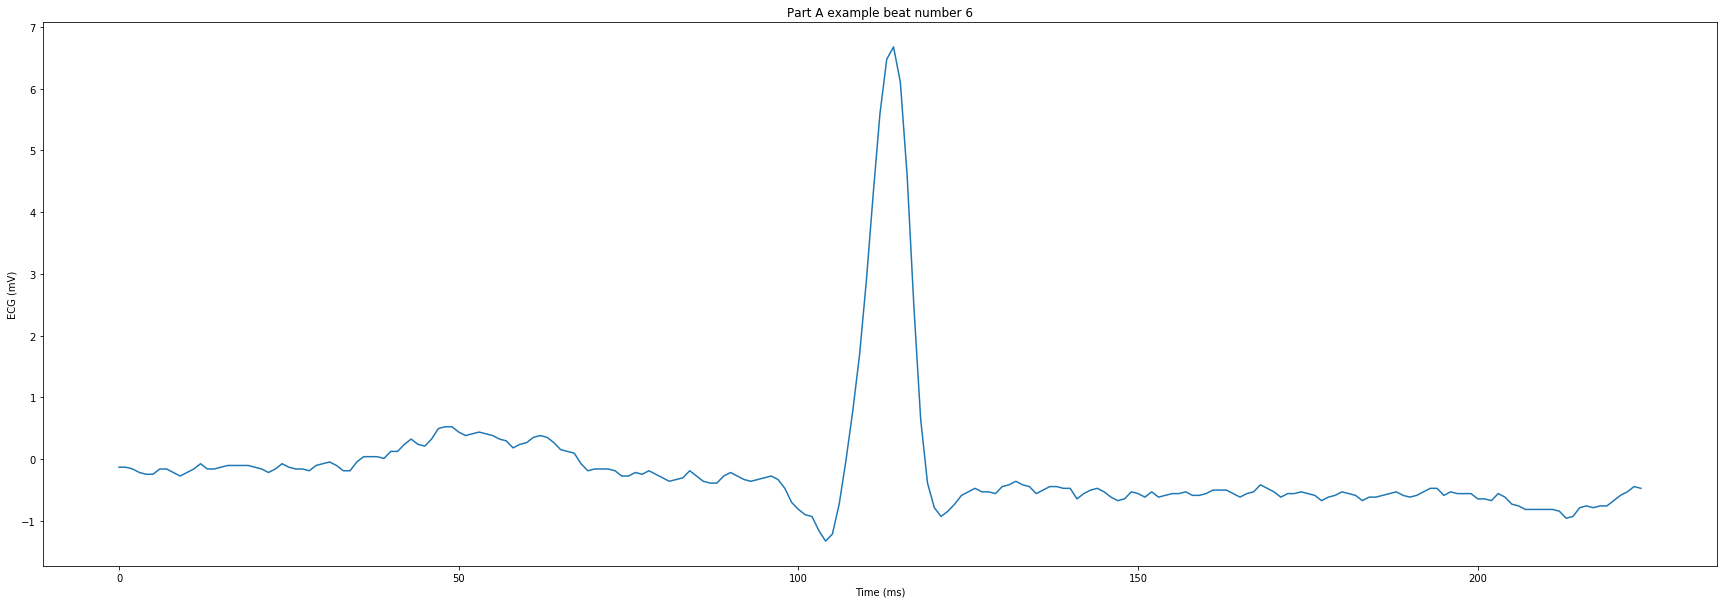

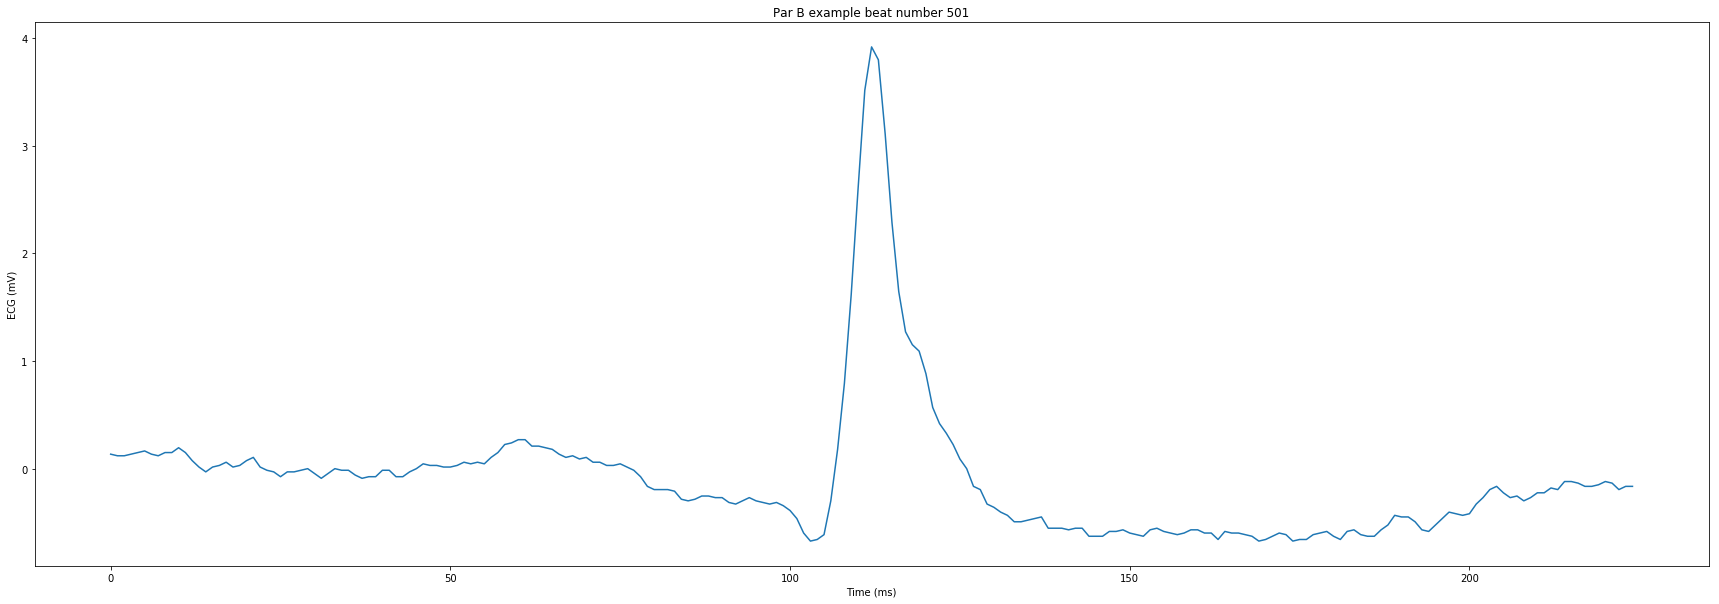

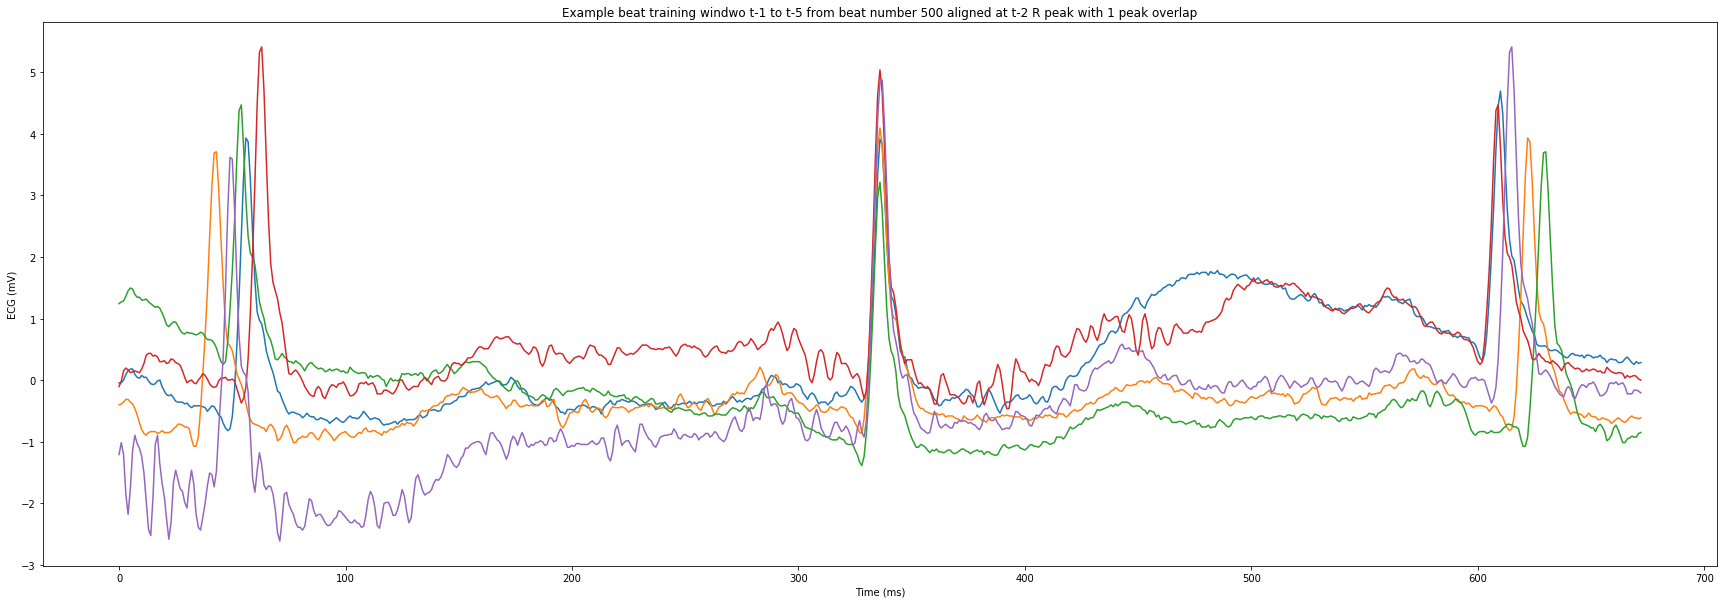

In [25]:
wr = 3 #average amount of heart beats/R peaks for a segment
ws = 2 #peak alignment for the windows counting from the direction of the arrythmic beat
over = 1 #peak overlap allowed between windows

dat = 500 #visualize which arrythmic window for part B
dat2 = 5 #visualize which beat for part A

nrry=[] #setting up list of predicted/expected beats for learning
arry=[] #setting up list of beat annotations for arry

allbeat=[] #a concatination of all individual beats
allbeatan=[] #annotations for allbeat

normalt1=[] #setting up list of input beat windows for arry t-1
normalt2=[] #t-2
normalt3=[] #t-3
normalt4=[] #t-4
normalt5=[] #t-5

annsym=[] #setting up annotation lists without non-beat annotations
annsam=[] #setting up annotation location list without non-beat annotations

Nb=[] #normal beat
Lb=[] #Left bundle branch block beat
Rb=[] #Right bundle branch block beat
Bb=[] #Bundle branch block beat (unspecified)
Ab=[] #Atrial premature beat
ab=[] #Aberrated atrial premature beat
Jb=[] #Nodal (junctional) premature beat
Sb=[] #Supraventricular premature or ectopic beat (atrial or nodal)
Vb=[] #Premature ventricular contraction
rb=[] #R-on-T premature ventricular contraction
Fb=[] #Fusion of ventricular and normal beat
eb=[] #Atrial escape beat
jb=[] #Nodal (junctional) escape beat
nb=[] #Supraventricular escape beat (atrial or nodal)
Eb=[] #Ventricular escape beat
Pb=[] #Paced beat actual symbol /
fb=[] #Fusion of paced and normal beat
Qb=[] #Unclassifiable beat

hry=[]
tlen=[]
for i in range(len(hrs)):
    hrs2 = hrs[i][~np.isnan(hrs[i])]
    hry.append(sum(hrs2[~np.isinf(hrs2)]) / len(hrs2[~np.isinf(hrs2)])) #average heart rate
    tlen.append(int(recordall[i].fs / (hry[i] / 60)))
#Set the total length of the segmented data to specified wr times the average heart rate

ttlen=tlen
tlen=sum(ttlen)/len(ttlen) #averages data length across patients for a global number to use

abl=['L','R','B','A','a','J','S','V','r','F','e','j','n','E','P','f','Q'] #list of abnormal beats
bbl=['[','!',']','x','(',')','p','t','u','`','%','^','|','~','+','s','T','*','D','=','"','@'] #list of non-beat annotations

#peak_inds are the peak found through calculation while annall[datanumb] is the annotated peaks

for t in range(len(annall)):
    annsymb=[]
    annsamb=[]
    for i in range(len(annall[t].symbol)): #This is to eliminate non-R-peak annotations in the data
        if annall[t].symbol[i] not in bbl:
            annsymb = np.append(annsymb, annall[t].symbol[i])
            annsamb = np.append(annsamb, annall[t].sample[i])
    annsym.append(annsymb)
    annsam.append(annsamb)

for i in range(len(annsym)):
    Nb.append([i for i, x in enumerate(annsym[i]) if x == "N"]) #get indices of all the different beats for later use
    Lb.append([i for i, x in enumerate(annsym[i]) if x == "L"])
    Rb.append([i for i, x in enumerate(annsym[i]) if x == "R"])
    Bb.append([i for i, x in enumerate(annsym[i]) if x == "B"])
    Ab.append([i for i, x in enumerate(annsym[i]) if x == "A"])
    ab.append([i for i, x in enumerate(annsym[i]) if x == "a"])
    Jb.append([i for i, x in enumerate(annsym[i]) if x == "J"])
    Sb.append([i for i, x in enumerate(annsym[i]) if x == "S"])
    Vb.append([i for i, x in enumerate(annsym[i]) if x == "V"])
    rb.append([i for i, x in enumerate(annsym[i]) if x == "r"])
    Fb.append([i for i, x in enumerate(annsym[i]) if x == "F"])
    eb.append([i for i, x in enumerate(annsym[i]) if x == "e"])
    jb.append([i for i, x in enumerate(annsym[i]) if x == "j"])
    nb.append([i for i, x in enumerate(annsym[i]) if x == "n"])
    Eb.append([i for i, x in enumerate(annsym[i]) if x == "E"])
    Pb.append([i for i, x in enumerate(annsym[i]) if x == "/"])
    fb.append([i for i, x in enumerate(annsym[i]) if x == "f"])
    Qb.append([i for i, x in enumerate(annsym[i]) if x == "Q"])


#This first part A is to separate each beat individualy using the average heart rate. Included with it will be other features extracted
#from manual peak detection. Not currently used.

for t in range(len(pchannel)):
    for i in range(len(annsym[t])):
        if (i-ws-4*wr+4*over) > 0 and annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2 > 0 and annsam[t][i]+tlen/2 < len(pchannel[t]): #make sure the beats we get are within the window ranges
            allbeat.append(pchannel[t][int(annsam[t][i]-tlen/2):int(annsam[t][i]+tlen/2)])
            #append all beats
            allbeatan.append(annsym[t][i])
            #append all annotations aligning with the beats
    
plt.figure(figsize=(30,10))
plt.plot(allbeat[dat2])
plt.title('Part A example beat number '+str(dat2+1))
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')
print('Part A beat type: '+allbeatan[dat2])

#This second part B is to see if the beats before the arrythmic beat could be used to predict the arrythmic beat. This will use raw lagged
#data as the input and the arrythmic beats themselves as the desired output. For data consistency, the data length will be
#normalized to the length of the number of heartbeats specified in wr according to the average heart rate. All of the data
#will also be aligned to specific peaks for data point alignment to optimize training.


for t in range(len(annsym)):
    for i in range(len(annsym[t])):
        if (i-ws-4*wr+4*over) > 0 and annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2 > 0 and annsam[t][i]+tlen/2 < len(pchannel[t]) and int(annsam[t][i-ws]+ws*tlen-tlen/2) < int(annsam[t][i]-tlen/2): #skips over beats that can't accomdate all time frames
            nrry.append(pchannel[t][int(annsam[t][i]-tlen/2):int(annsam[t][i]+tlen/2)])
            arry.append(annsym[t][i])
            #append all delayed windows
            normalt1.append(pchannel[t][int(annsam[t][i-ws]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws]+ws*tlen-tlen/2)]) 
            normalt2.append(pchannel[t][int(annsam[t][i-ws-wr+over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-wr+over]+ws*tlen-tlen/2)])
            normalt3.append(pchannel[t][int(annsam[t][i-ws-2*wr+2*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-2*wr+2*over]+ws*tlen-tlen/2)])
            normalt4.append(pchannel[t][int(annsam[t][i-ws-3*wr+3*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-3*wr+3*over]+ws*tlen-tlen/2)])
            normalt5.append(pchannel[t][int(annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-4*wr+4*over]+ws*tlen-tlen/2)])
            #append all different data windows right before the annotated beats       

plt.figure(figsize=(30,10))
plt.plot(nrry[dat])
plt.title('Par B example beat number '+str(dat+1))
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')
print('Part B label of beat is '+arry[dat])

plt.figure(figsize=(30,10))
plt.plot(normalt1[dat])
plt.plot(normalt2[dat])
plt.plot(normalt3[dat])
plt.plot(normalt4[dat])
plt.plot(normalt5[dat])
plt.title('Example beat training windwo t-1 to t-5 from beat number '+str(dat)+' aligned at t-'+str(ws)+' R peak with '+str(over)+' peak overlap')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')


    

In order to prevent the large amount of normal heart beats overshadowing the learning algorithms, we downsample the normal beats to the total amount of arrythmic beats found in the data.

In [27]:
df_a = pd.DataFrame(data=arry, columns=['Beats']) #Set the labels as dataframe for normal vs arrythmic extraction
df_n = pd.DataFrame(data=nrry) #set all data as dataframes for easier downsampling
df_1 = pd.DataFrame(data=normalt1)
df_2 = pd.DataFrame(data=normalt2)
df_3 = pd.DataFrame(data=normalt3)
df_4 = pd.DataFrame(data=normalt4)
df_5 = pd.DataFrame(data=normalt5)
idxN = df_a.index[df_a['Beats'] == 'N'].tolist()
idxA = df_a.index[df_a['Beats'] != 'N'].tolist()
df_a_normal = df_a.loc[idxN] #Split all dataset the same way so that every sample lines up across each dataframe
df_a_arrythmic = df_a.loc[idxA]
df_n_normal = df_n.loc[idxN]
df_n_arrythmic = df_n.loc[idxA]
df_1_normal = df_1.loc[idxN]
df_1_arrythmic = df_1.loc[idxA]
df_2_normal = df_2.loc[idxN]
df_2_arrythmic = df_2.loc[idxA]
df_3_normal = df_3.loc[idxN]
df_3_arrythmic = df_3.loc[idxA]
df_4_normal = df_4.loc[idxN]
df_4_arrythmic = df_4.loc[idxA]
df_5_normal = df_5.loc[idxN]
df_5_arrythmic = df_5.loc[idxA]

idx = np.random.choice(df_a_normal.index, len(df_a_arrythmic), replace=False) #create a random index for downsampling based on the number of arrythmic beats
df_a_downsampled = df_a_normal.loc[idx]
df_n_downsampled = df_n_normal.loc[idx]
df_1_downsampled = df_1_normal.loc[idx]
df_2_downsampled = df_2_normal.loc[idx]
df_3_downsampled = df_3_normal.loc[idx]
df_4_downsampled = df_4_normal.loc[idx]
df_5_downsampled = df_5_normal.loc[idx]

df_a = pd.concat([df_a_downsampled, df_a_arrythmic]).sort_index() #put the normal and arrythmic beats together again
df_n = pd.concat([df_n_downsampled, df_n_arrythmic]).sort_index()
df_1 = pd.concat([df_1_downsampled, df_1_arrythmic]).sort_index()
df_2 = pd.concat([df_2_downsampled, df_2_arrythmic]).sort_index()
df_3 = pd.concat([df_3_downsampled, df_3_arrythmic]).sort_index()
df_4 = pd.concat([df_4_downsampled, df_4_arrythmic]).sort_index()
df_5 = pd.concat([df_5_downsampled, df_5_arrythmic]).sort_index()

arry = np.array(df_a) #change the dataframes back into arrays for later operations
nrry = np.array(df_n)
normalt1 = np.array(df_1)
normalt2 = np.array(df_2)
normalt3 = np.array(df_3)
normalt4 = np.array(df_4)
normalt5 = np.array(df_5)

arryb=np.array(arry)
#Set beat annotation to binary for learning later
for n, i in enumerate(arryb):
    if i == 'N':
        arryb[n] = 0
    else:
        arryb[n] = 1

df_a['Beats'].value_counts()

N    3582
R    1134
L    1043
/     584
V     523
A     212
F      54
f      27
a       2
e       2
J       1
Name: Beats, dtype: int64

Attempts at raw data decomposition for part B: transforming the different time windows from segmentation will allow us to bypass timing restrictions. First to try is Fourier Transform.

Text(0.5,1,'Fourier transforms of t-1 to t-5 time windows for the first arrythmic beat of data #122')

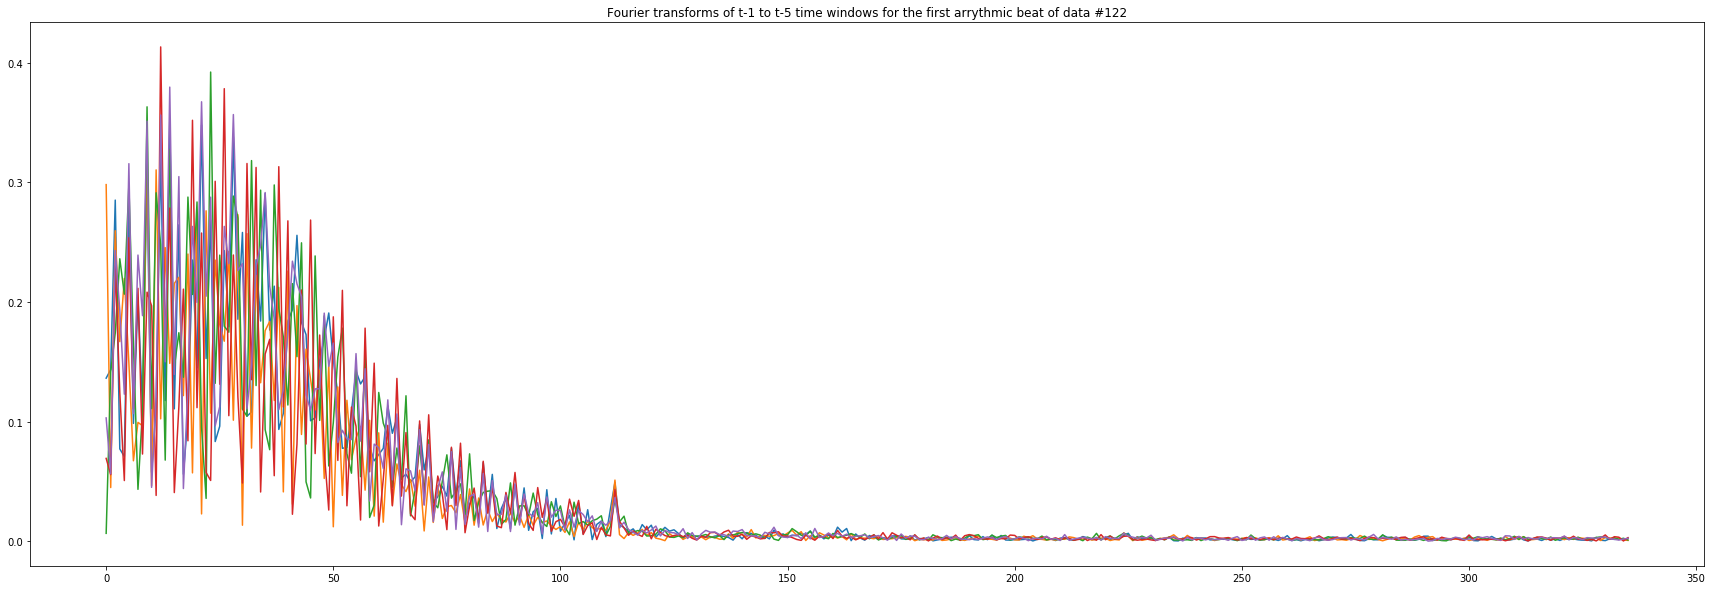

In [8]:
#Fourier transform of normalt raw data windows
fnormalt1=[]
fnormalt2=[]
fnormalt3=[]
fnormalt4=[]
fnormalt5=[]

N = len(normalt1[0]) #number of sample points

for i in range(len(normalt5)):
    try:
        fnormalt1.append(fft(normalt1[i])) #Fourier transform of all data
        fnormalt2.append(fft(normalt2[i]))
        fnormalt3.append(fft(normalt3[i]))
        fnormalt4.append(fft(normalt4[i]))
        fnormalt5.append(fft(normalt5[i]))
    except ValueError:
        pass
plt.figure(figsize=(30,10))
plt.plot(2.0/N * np.abs(fnormalt1[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt2[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt3[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt4[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt5[0][:N//2]))
plt.title('Fourier transforms of t-1 to t-5 time windows for the first arrythmic beat of data #'+file_nums[datanumb])

Using the Fourier Transforms above as well as the raw data from part B, this part reduces the complexity of the data using PCA and initiates the linear prediction algorithm in the following cell. The Linear Regression model is simply a fast way of evaluating whether or not our data prep steps worked and isn't useful outside of that goal.

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


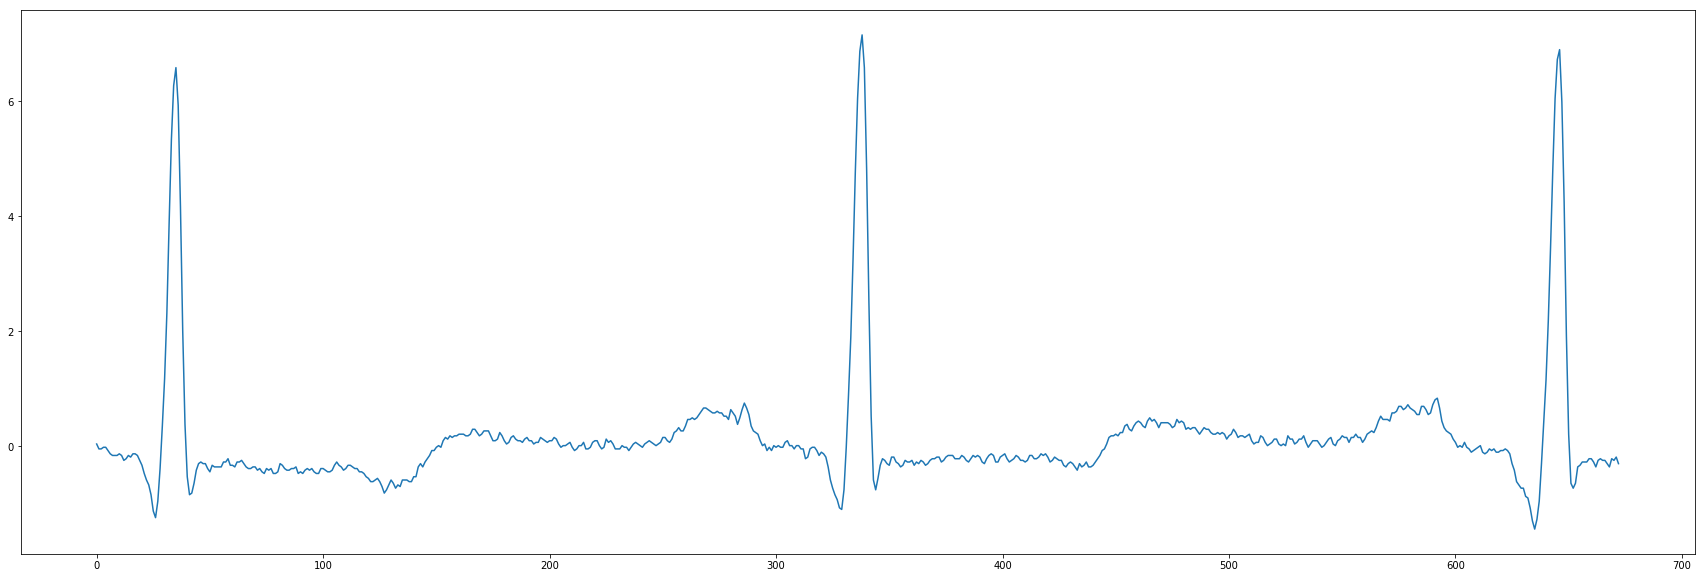

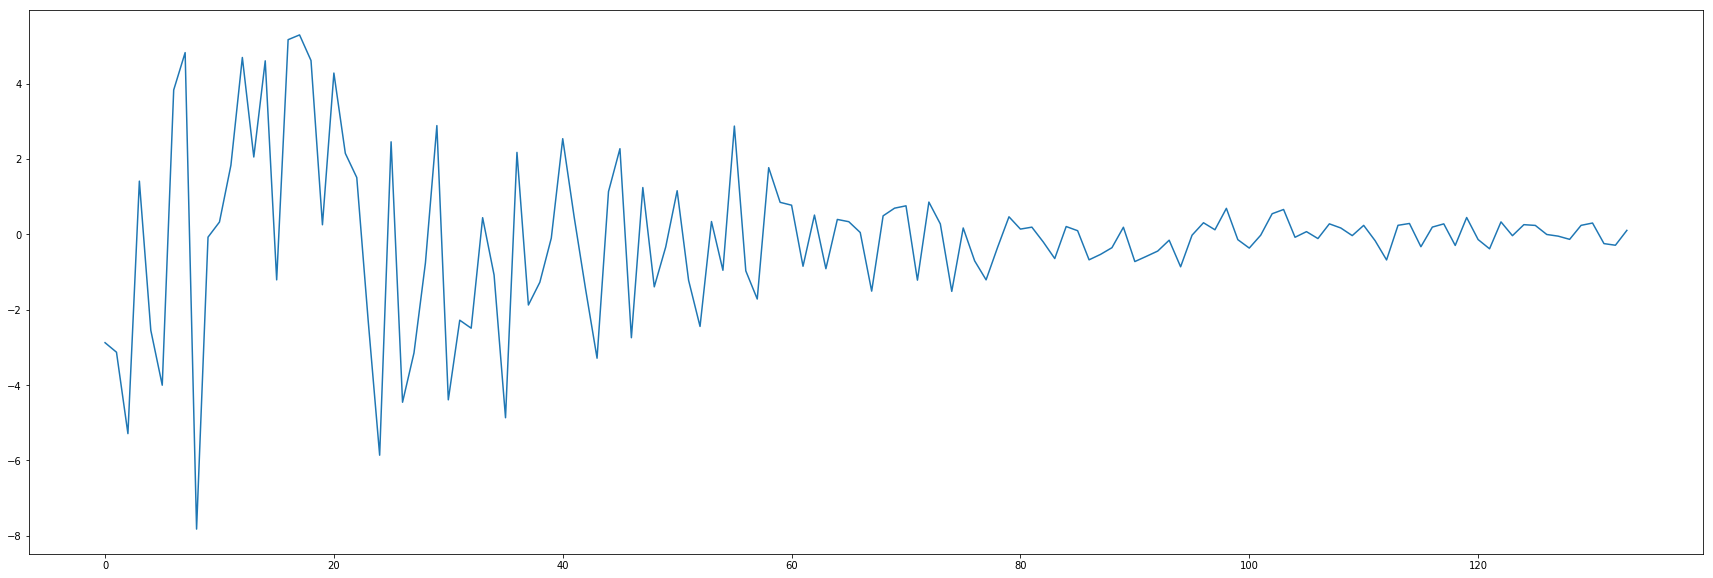

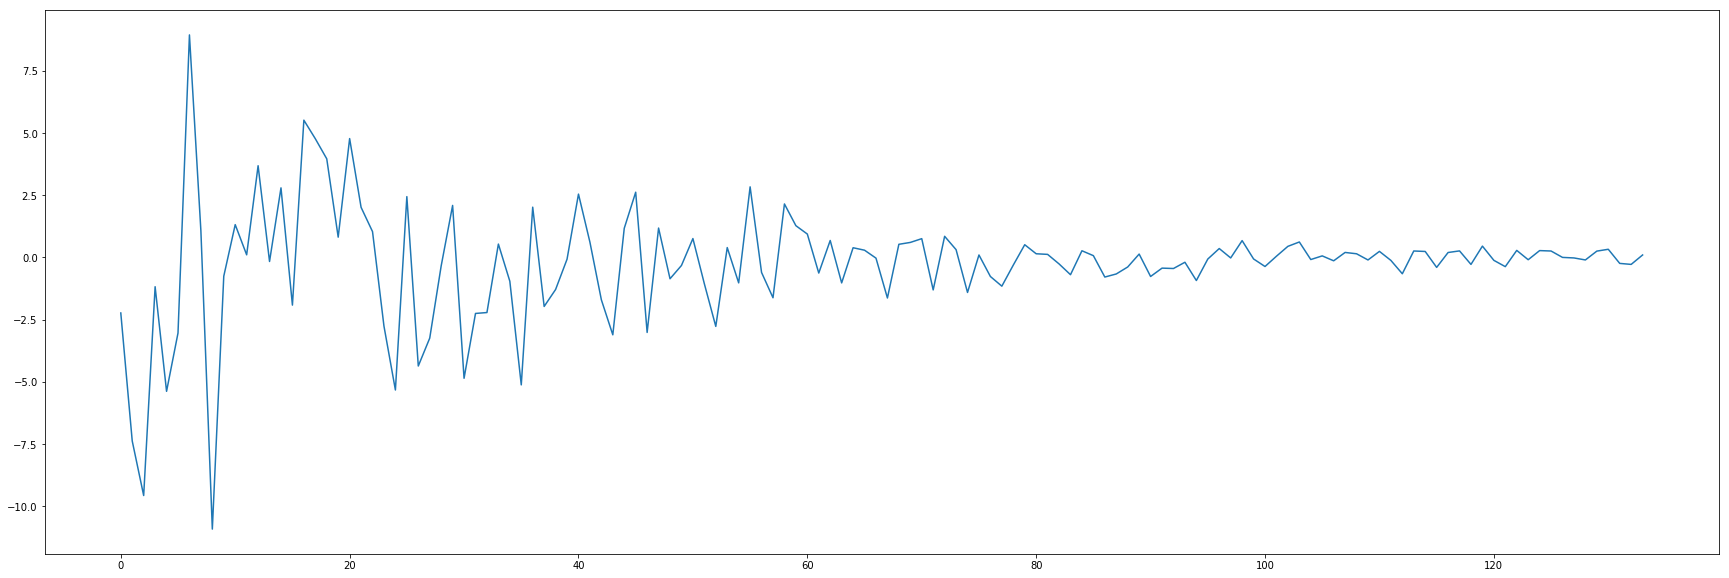

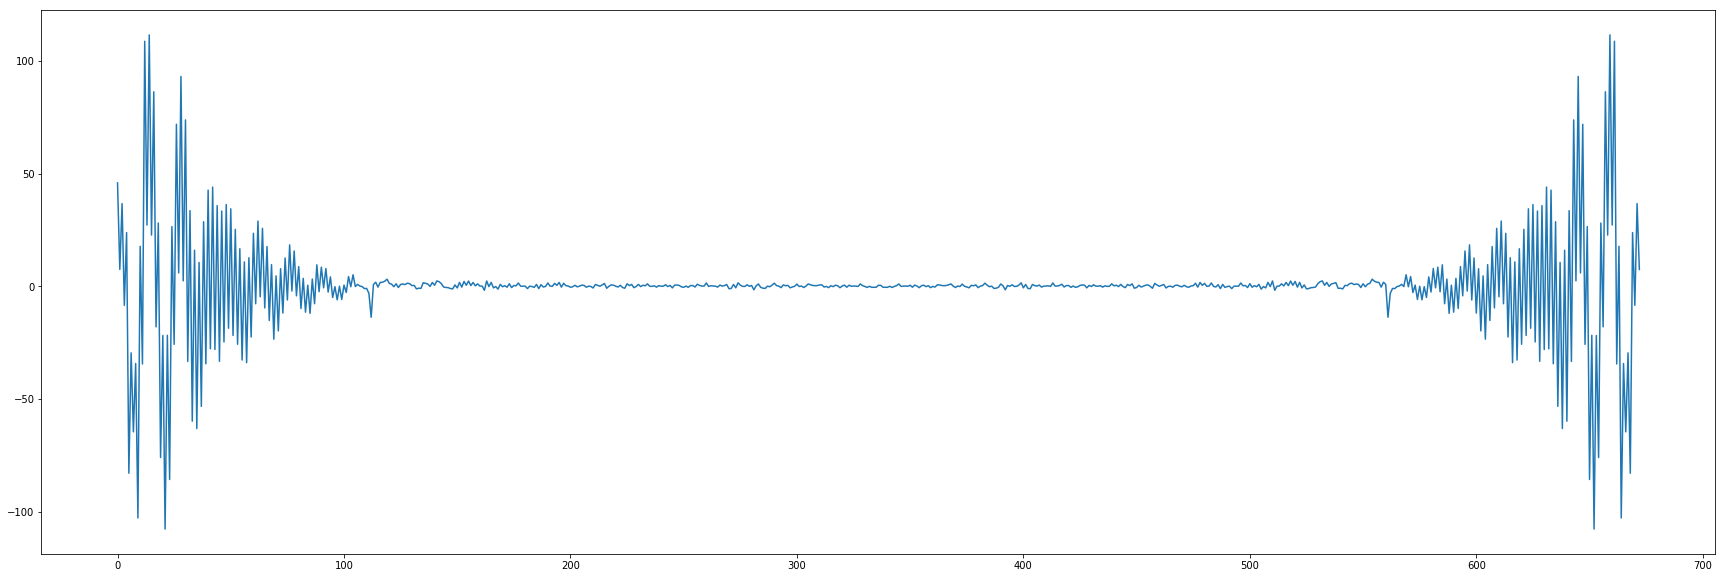

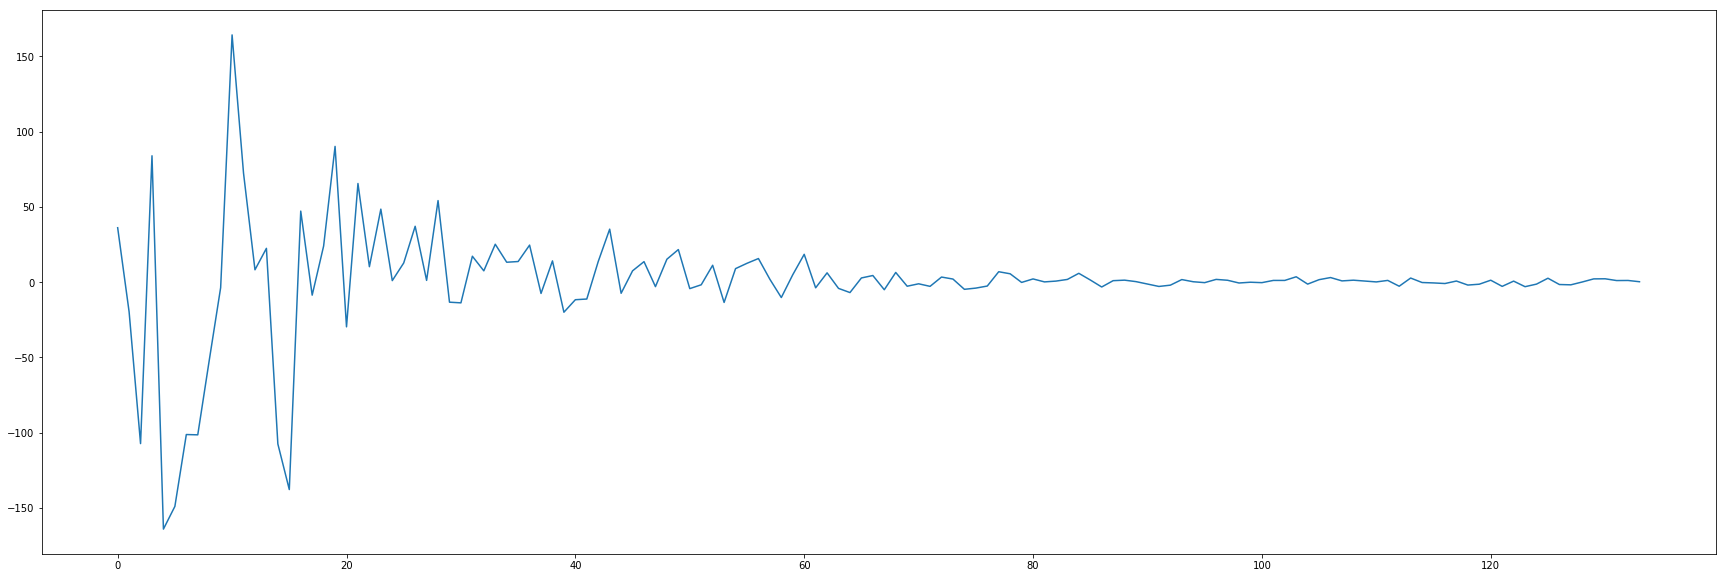

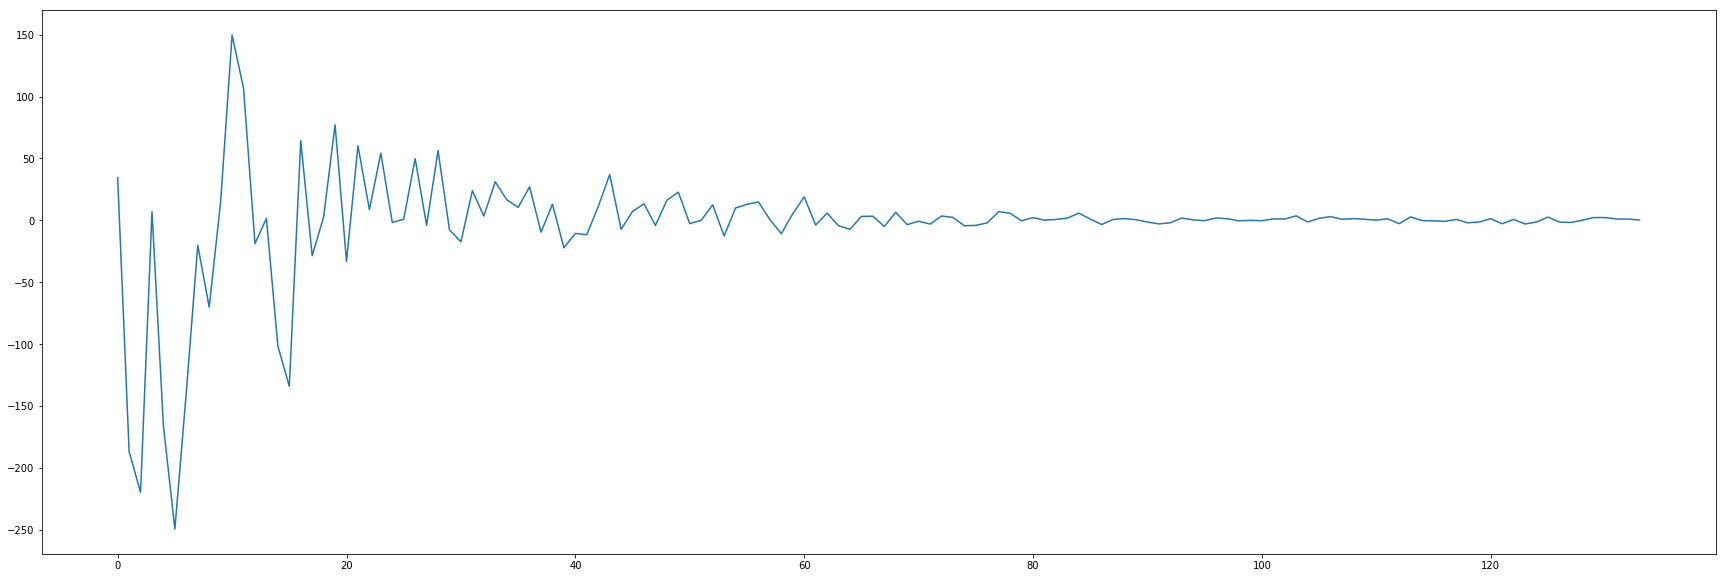

In [31]:
pca = PCA(n_components = int(len(normalt1[0])/5)) #the number of PCs is limited to a fraction of the data/features

alln=np.concatenate((np.array(normalt1),np.array(normalt2),np.array(normalt3)), axis=1) #np.array(normalt4),np.array(normalt5)),axis=1) #set up an array to learn across all time windows at once
allf=np.concatenate((np.array(fnormalt1),np.array(fnormalt2),np.array(fnormalt3)), axis=1) #np.array(fnormalt4),np.array(fnormalt5)),axis=1) #all time windows in the frequency domain

reducedn = pca.fit_transform(alln) #PCA on all time windows
reducednpc = pca.components_ #Get the principal components
coefn = matmul(alln,transpose(reducednpc)) #calculate the weights for learning

reducedn1 = pca.fit_transform(np.array(normalt1)) #PCA on the first time window only
reducedn1pc = pca.components_
coefn1 = matmul(np.array(normalt1),transpose(reducedn1pc))

reducedf = pca.fit_transform(allf) #PCA on all frequency transforms
reducedfpc = pca.components_
coeff = matmul(allf,transpose(reducedfpc))

reducedf1 = pca.fit_transform(np.array(fnormalt1)) #PCA on the frequency domain of the first window only
reducedf1pc = pca.components_
coeff1 = matmul(np.array(fnormalt1),transpose(reducedf1pc))

plt.figure(figsize=(30,10))
plt.plot(normalt1[0])
plt.figure(figsize=(30,10))
plt.plot(reducedn1[0])
plt.figure(figsize=(30,10))
plt.plot(coefn1[0])
plt.figure(figsize=(30,10))
plt.plot(fnormalt1[0])
plt.figure(figsize=(30,10))
plt.plot(reducedf1[0])
plt.figure(figsize=(30,10))
plt.plot(coeff1[0])

In [ ]:
nrry=np.array(nrry)
arry=np.array(arry)
arryb=np.array(arryb)
tarry=np.concatenate((arry, arry, arry, arry, arry))
tnrry=np.concatenate((nrry, nrry, nrry, nrry, nrry))

LR = LinearRegression() #setup linear regression

X_fit, X_eval, y_fit, y_eval= TTS(normalt1, nrry, test_size=0.15, random_state=1) #split data into training and test groups randomly
#This linear regression looks at only the first time window before predicdtion
a = LR.fit(X=X_fit, y=y_fit) #fit the data
b = LR.predict(X_eval) #get a prediction based on fit
c = LR.score(X_eval,y_eval) #evaluate the difference between predicted and actual outcomes

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using raw first window input is: '+str(c))

#Linear regression for Fourier transformed first window
X_fit, X_eval, y_fit, y_eval= TTS(fnormalt1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using transformed first window input is: '+str(c))
#Linear regression for PCA transformed first time window
X_fit, X_eval, y_fit, y_eval= TTS(coefn1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of first window input is: '+str(c))
#Linear regresion for PCA transformed Fourier transforms of first window
X_fit, X_eval, y_fit, y_eval= TTS(coeff1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of transformed first window input is: '+str(c))
#Linear regression of all window data
X_fit, X_eval, y_fit, y_eval= TTS(alln, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using all raw inputs is: '+str(c))
#Linear regression of all Fourier transformed window data
X_fit, X_eval, y_fit, y_eval= TTS(allf, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using all transformed input is: '+str(c))
#Linear regression of all PCA transformed data
X_fit, X_eval, y_fit, y_eval= TTS(coefn, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of all raw input is: '+str(c))
#Linear regression of PCA transformed Fourier transforms of all data
X_fit, X_eval, y_fit, y_eval= TTS(coeff, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of all transformed input is: '+str(c))



Using Gridsearch to optimize pararmters for Logistic Regression, Random Forest Classifier, Gradient Boosting Classifier, and Multi-layered Perceptron Classifier

In [31]:
X_train, X_test, y_train, y_test= TTS(alln, np.ravel(arryb).astype('int'), test_size=0.15, random_state=1)
X_trainb=[]
X_testb=[]
y_trainb=[]
y_testb=[]  #split data into training and test sets
for i in range(len(X_train)): #downsample the data to 1/5 of its entirety for speeding up gridsearch
    if i % 5 == 0:
        X_trainb.append(X_train[i])
        y_trainb.append(y_train[i])
for t in range(len(X_test)):
    if t % 5 == 0:
        X_testb.append(X_test[t])
        y_testb.append(y_test[t])
X_trainb = np.array(X_trainb)
X_testb = np.array(X_testb)
y_trainb = np.array(y_trainb)
y_testb = np.array(y_testb)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()), #logistic regression
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()), #logistic regression plus PCA
            ('pca', PCA(n_components=int(len(normalt1[0])/5))),
            ('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()), #random forrest classifier
            ('clf', RFC(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()), #random forrest classifier plus PCA
            ('pca', PCA(n_components=int(len(normalt1[0])/5))),
            ('clf', RFC(random_state=42))])

pipe_gbc = Pipeline([('scl', StandardScaler()), #gradient boost classifier
            ('clf', GBC(random_state=42))])

pipe_gbc_pca = Pipeline([('scl', StandardScaler()), #gradient boost classifier plus PCA
            ('pca', PCA(n_components=int(len(normalt1[0])/5))),
            ('clf', GBC(random_state=42))])

pipe_mlpc = Pipeline([('scl', StandardScaler()), #Multi-layered perceptron classifier
            ('clf', MLPC(random_state=42))])

pipe_mlpc_pca = Pipeline([('scl', StandardScaler()), #Multi-layered perceptron classifier plus PCA
            ('pca', PCA(n_components=int(len(normalt1[0])/5))),
            ('clf', MLPC(random_state=42))])


# Set grid search params
param_range = [1, 3, 5, 7, 9]
param_range_lg = [0.01, 0.1, 1, 10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_estimators = [10, 50, 100, 500]
param_range_lr = [0.05, 0.1, 0.3, 0.5]
param_range_dpt = [1, 10, 100]
param_range_sm = [0.0001, 0.001, 0.01, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'], #params for logistic regression
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'], #params for random forrest classifier
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range_dpt,
        'clf__min_samples_split': param_range[1:]}]

grid_params_gbc = [{'clf__learning_rate': param_range_lr, #params for gradient boost classifier
        'clf__n_estimators': param_range_estimators,
        'clf__max_depth': param_range}]

grid_params_mlpc = [{'clf__hidden_layer_sizes': param_range_estimators, #params for MLP classifier
        'clf__alpha': param_range_sm,
        'clf__learning_rate_init': param_range_sm}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10, verbose = 2) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10, verbose = 2)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs, verbose = 2)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs, verbose = 2)

gs_gbc = GridSearchCV(estimator=pipe_gbc,
            param_grid=grid_params_gbc,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs, verbose = 2)

gs_gbc_pca = GridSearchCV(estimator=pipe_gbc_pca,
            param_grid=grid_params_gbc,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs, verbose = 2)

gs_mlpc = GridSearchCV(estimator=pipe_mlpc,
            param_grid=grid_params_mlpc,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs, verbose = 2)

gs_mlpc_pca = GridSearchCV(estimator=pipe_mlpc_pca,
            param_grid=grid_params_mlpc,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs, verbose = 2)


# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca] #gs_mlpc, gs_mlpc_pca, gs_gbc, gs_gbc_pca

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'Logistic Regression',
        1: 'Logistic Regression w/ PCA',
        2: 'Random Forest', 3: 'Random Forest w/PCA', 
        4: 'Multilayered Perceptron Classifier', 5: 'Multilayered Perceptron Classifier w/ PCA', 
        6: 'Gradient Boosting Classifier', 7:'Gradient Boosting Classifier w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    gs.fit(X_trainb, y_trainb)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_testb)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_testb, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_testb, y_pred) > best_acc:
        best_acc = accuracy_score(y_testb, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   1.1s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.8s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   1.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   1.1s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.7s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   1.1s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   1.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   1.1s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............

[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, total=   1.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.3min finished


Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.847
Test set accuracy score for best params: 0.841 

Estimator: Logistic Regression w/ PCA
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, total=   0.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............

[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, total=   0.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   21.9s finished


Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.841
Test set accuracy score for best params: 0.806 

Estimator: Random Forest
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.1min finished


Best params: {'clf__criterion': 'gini', 'clf__max_depth': 100, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 9}
Best training accuracy: 0.878
Test set accuracy score for best params: 0.857 

Estimator: Random Forest w/PCA
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  5.3min finished


Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 100, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 5}
Best training accuracy: 0.821
Test set accuracy score for best params: 0.814 

Classifier with best test set accuracy: Random Forest


Below are the first run with 5 time windows, MLII, V1, and V5 channels.

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.533
Test set accuracy score for best params: 0.544 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.525
Test set accuracy score for best params: 0.585 

Estimator: Random Forest
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10}
Best training accuracy: 0.607
Test set accuracy score for best params: 0.609 

Estimator: Random Forest w/PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 9}
Best training accuracy: 0.594
Test set accuracy score for best params: 0.587 

Classifier with best test set accuracy: Random Forest

Below is the second run using MLII only and 3 time windows.

Performing model optimizations...

Estimator: Multilayered Perceptron Classifier
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best params: {'clf__alpha': 0.1, 'clf__hidden_layer_sizes': 500, 'clf__learning_rate_init': 0.0001}
Best training accuracy: 0.876
Test set accuracy score for best params: 0.872 

Estimator: Multilayered Perceptron Classifier w/ PCA
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best params: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': 500, 'clf__learning_rate_init': 0.001}
Best training accuracy: 0.872
Test set accuracy score for best params: 0.841 

Estimator: Gradient Boosting Classifier
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 500}
Best training accuracy: 0.891
Test set accuracy score for best params: 0.888 

Estimator: Gradient Boosting Classifier w/PCA
Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 500}
Best training accuracy: 0.867
Test set accuracy score for best params: 0.857 

Estimator: Logistic Regression
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.847
Test set accuracy score for best params: 0.841 

Estimator: Logistic Regression w/ PCA
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.841
Test set accuracy score for best params: 0.806 

Estimator: Random Forest
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 100, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 9}
Best training accuracy: 0.878
Test set accuracy score for best params: 0.857 

Estimator: Random Forest w/PCA
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 100, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 5}
Best training accuracy: 0.821
Test set accuracy score for best params: 0.814 

Classifier with best test set accuracy: Gradient Boosting Classifier

In [35]:
X_train, X_test, y_train, y_test= TTS(alln, np.ravel(arryb).astype('int'), test_size=0.20, random_state=1)

pipe_mlpc = Pipeline([('scl', StandardScaler()), #Multi-layered perceptron classifier
            ('clf', MLPC(hidden_layer_sizes=500, alpha= 0.1, learning_rate_init= 0.0001, random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()), #random forrest classifier
            ('clf', RFC(criterion='gini', max_depth=100, min_samples_leaf = 5, min_samples_split = 10, random_state=42))])

pipe_gbc = Pipeline([('scl', StandardScaler()), #gradient boost classifier
            ('clf', GBC(learning_rate = 0.05, max_depth = 7, n_estimators = 500, random_state=42))])

pipe_mlpc_pca = Pipeline([('scl', StandardScaler()), #Multi-layered perceptron classifier plus PCA
            ('pca', PCA(n_components=int(len(alln[0])/5))),
            ('clf', MLPC(hidden_layer_sizes=500, alpha= 0.1, learning_rate_init= 0.0001, max_iter = 400, random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()), #random forrest classifier plus PCA
            ('pca', PCA(n_components=int(len(alln[0])/5))),
            ('clf', RFC(criterion='entropy', max_depth=100, min_samples_leaf = 5, min_samples_split = 10, random_state=42))])

pipe_gbc_pca = Pipeline([('scl', StandardScaler()), #gradient boost classifier plus PCA
            ('pca', PCA(n_components=int(len(alln[0])/5))),
            ('clf', GBC(learning_rate = 0.05, max_depth = 7, n_estimators = 500, random_state=42))])

pipe_lr = Pipeline([('scl', StandardScaler()), #logistic regression
            ('clf', LogisticRegression(C=0.1, penalty = 'l2', random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()), #logistic regression plus PCA
            ('pca', PCA(n_components=int(len(alln[0])/5))),
            ('clf', LogisticRegression(C=0.1, penalty = 'l2', random_state=42))])

scores = cross_val_score(pipe_mlpc, alln, np.ravel(arryb).astype('int'), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

pipe_mlpc.fit(X_train, y_train)
y_pred = pipe_mlpc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

Accuracy: 0.71 (+/- 0.29)
0.9309141660851361


MLPC- CV Accuracy: 0.75 (+/- 0.21) based on above gridsearch parameters, it's the same after changing hidden layer to 250, prediction accuracy: 0.8784883720930232

MLPC with PCA- CV Accuracy: 0.75 (+/- 0.19) based on above gridsearch parameters, has many convergence warnings, prediction accuracy: 0.8843023255813953

Random Forest Classifier- CV Accuracy: 0.78 (+/- 0.16), 0.79 with min_samples_leaf=5, 0.80 with leaf =10, split = 50, prediction accuracy: 0.8924418604651163

Random Forest Classifier with PCA- CV Accuracy: 0.71 (+/- 0.17), prediction accuracy: 0.8133720930232559

Logistic Regression- CV Accuracy: 0.68 (+/- 0.26), prediction accuracy: 0.8482558139534884

Logistic Regression with PCA- CV Accuracy: 0.68 (+/- 0.26), prediction accuracy: 0.8470930232558139



After looking back at window separation, I noticed that there's a chance that the first window (normalt1) could overlap with the classified beat given a certain heart rate (since the windows of beats are a set length based on average heart rate). I then took out the beats that have this overlap and re-ran pipelines. These calculations are all using 3 windows, 3 beats per window, centering on the middle beat, and 1 beat overlap.

Random Forest Classifier: CV Accuracy: 0.79 (+/- 0.24) and predition accuracy: 0.9371946964410328
Random forest classifier with PCA: CV Accuracy: 0.68 (+/- 0.23) and prediction accuracy: 0.8590369853454292
MLP Classifier: CV accuracy: Accuracy: 0.71 (+/- 0.29) and prediction accuracy: 0.9309141660851361

